# Incubator State Estimation with a Kalman Filter

Next we contruct the kalman filter, using the system sympy library to transform the system symbolic equations to a discrete time system.
We adjust the equations from [ModellingIncubatorDynamics](../3-Physics-Modelling/2-ModellingIncubatorDynamics.ipynb).

In [1]:
%pip install control
%pip install plotly
%pip install filterpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sympy as sp
import numpy as np
from control import ss

# Parameters
C_air = sp.Symbol("C_air", real=True)  # Specific heat capacity
G_box = sp.Symbol("G_box", real=True)  # Specific heat capacity
C_heater = sp.Symbol("C_heater", real=True)  # Specific heat capacity
G_heater = sp.Symbol("G_heater", real=True)  # Specific heat capacity

# Constants
V_heater = sp.Symbol("V_heater", real=True)
i_heater = sp.Symbol("i_heater", real=True)

# Inputs
in_room_temperature = sp.Symbol("T_room", real=True)
on_heater = sp.Symbol("on_heater", real=True)

# States
T = sp.Symbol("T", real=True)
T_heater = sp.Symbol("T_h", real=True)

power_in = on_heater * V_heater * i_heater

power_transfer_heat = G_heater * (T_heater - T)

total_power_heater = power_in - power_transfer_heat

power_out_box = G_box * (T - in_room_temperature)

total_power_box = power_transfer_heat - power_out_box

der_T = (1.0 / C_air) * (total_power_box)
der_T_heater = (1.0 / C_heater) * (total_power_heater)

# Turn above into a continuous time linear system
"""
States are:
[[ T_heater ]
[ T        ]]

Inputs are: 
[ [ on_heater ], 
[ in_room_temperature ]]
"""

# We use the derivative (diff) as a shortcut to get the terms 
#  that need to be multiplied by each state in A*x
A = sp.Matrix([
    [der_T_heater.diff(T_heater),   der_T_heater.diff(T)],
    [der_T.diff(T_heater),          der_T.diff(T)       ]
])

B = sp.Matrix([
    [der_T_heater.diff(on_heater),  der_T_heater.diff(in_room_temperature)  ],
    [der_T.diff(on_heater),         der_T.diff(in_room_temperature)         ]
])

# Observation matrix: only T can be measured, not T_heater.
C = sp.Matrix([[0.0, 1.0]])

In [3]:
print(der_T)

1.0*(-G_box*(T - T_room) + G_heater*(-T + T_h))/C_air


In [4]:
print(der_T_heater)

1.0*(-G_heater*(-T + T_h) + V_heater*i_heater*on_heater)/C_heater


In [5]:
A

Matrix([
[-1.0*G_heater/C_heater,         1.0*G_heater/C_heater],
[    1.0*G_heater/C_air, 1.0*(-G_box - G_heater)/C_air]])

In [6]:
B

Matrix([
[1.0*V_heater*i_heater/C_heater,               0],
[                             0, 1.0*G_box/C_air]])

In [7]:
C

Matrix([[0.0, 1.0]])

In [8]:
# System parameters
V_heater_num = HEATER_VOLTAGE = 12.0
i_heater_num = HEATER_CURRENT = 10.45
C_air_num = 68.21
G_box_num = 0.74 
C_heater_num = 243.46
G_heater_num = 0.87

# Replace constants and get numerical matrices
def replace_constants(m):
    return np.array(m.subs({
        V_heater: V_heater_num,
        i_heater: i_heater_num,
        C_air: C_air_num,
        G_box: G_box_num,
        C_heater: C_heater_num,
        G_heater: G_heater_num
    })).astype(np.float64)


In [9]:

# Numerical simulation parameters
STEP_SIZE = 3.0

# Numerical matrices
A_num = replace_constants(A)

B_num = replace_constants(B)

C_num = replace_constants(C)

D_num = np.array([[0.0, 0.0]])

ct_system = ss(A_num, B_num, C_num, D_num)
dt_system = ct_system.sample(STEP_SIZE, method="backward_diff")

dt_system

StateSpace(array([[0.9897684 , 0.00990909],
       [0.03536823, 0.93422594]]), array([[1.52941294e+00, 3.22506658e-04],
       [5.46518040e-02, 3.04058289e-02]]), array([[0.03536823, 0.93422594]]), array([[0.0546518 , 0.03040583]]), 3.0)

Now we have a discrete time linear system, we can construct the kalman filter.

In [10]:
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import KalmanFilter

initial_heat_temperature = 25.0
initial_box_temperature = 25.0

std_dev_measurement_noise = 0.9
std_dev_process_noise = 0.1

# This is the initial uncertainty (covariance matrix)
process_covariance_init = np.array([[100., 0.],
                                    [0., 100.]])

f = KalmanFilter(dim_x=2, dim_z=1, dim_u=2)
f.x = np.array([[initial_heat_temperature],  # T_heater at t=0
                [initial_box_temperature]])  # T at t=0
f.F = dt_system.A
f.B = dt_system.B
f.H = dt_system.C
f.P = process_covariance_init
f.R = np.array([[std_dev_measurement_noise]])
f.Q = Q_discrete_white_noise(dim=2, dt=STEP_SIZE, var=std_dev_process_noise ** 2)

f

KalmanFilter object
dim_x = 2
dim_z = 1
dim_u = 2
x = [[25. 25.]].T
P = [[100.   0.]
     [  0. 100.]]
x_prior = [[0. 0.]].T
P_prior = [[1. 0.]
           [0. 1.]]
x_post = [[0. 0.]].T
P_post = [[1. 0.]
          [0. 1.]]
F = [[0.9897684  0.00990909]
     [0.03536823 0.93422594]]
Q = [[0.2025 0.135 ]
     [0.135  0.09  ]]
R = [[0.9]]
H = [[0.03536823 0.93422594]]
K = [[0. 0.]].T
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = [[1.52941294e+00 3.22506658e-04]
     [5.46518040e-02 3.04058289e-02]]
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x000002BDFEDB2C00>

In [11]:
from data_handling import load_data
import pandas
import math

# Load the data
time_unit = 'ns'
data, _ = load_data("./lid_opening_experiment_jan_2021/lid_opening_experiment_jan_2021.csv",
                    HEATER_VOLTAGE, HEATER_CURRENT,
                    desired_timeframe=(- math.inf, math.inf),
                    time_unit=time_unit,
                    normalize_time=False,
                    convert_to_seconds=True)
events = pandas.read_csv("./lid_opening_experiment_jan_2021/events.csv")
events["timestamp_ns"] = pandas.to_datetime(events["time"], unit=time_unit)

data

,time,t1,time_t1,t2,time_t2,t3,time_t3,average_temperature,heater_on,fan_on,execution_interval,elapsed,timestamp_ns,power_in,avg_temp_kelvin,potential_energy,lid_open
0,1.611327e+09,21.312,1611326936960770000,25.000,1611326937840280000,24.812,1611326938720290000,24.9060,False,False,3,2.617681,2021-01-22 14:48:58.720290,0.0,298.0560,0.000,0.0
1,1.611327e+09,21.312,1611326940000310000,25.000,1611326940880730000,24.875,1611326941760290000,24.9375,False,False,3,2.657222,2021-01-22 14:49:01.760290,0.0,298.0875,0.882,0.0
2,1.611327e+09,21.312,1611326942960290000,25.000,1611326943840300000,24.812,1611326944720280000,24.9060,False,False,3,2.616798,2021-01-22 14:49:04.720280,0.0,298.0560,0.000,0.0
3,1.611327e+09,21.312,1611326946000330000,25.000,1611326946880260000,24.812,1611326947760260000,24.9060,False,False,3,2.656322,2021-01-22 14:49:07.760260,0.0,298.0560,0.000,0.0
4,1.611327e+09,21.312,1611326948960360000,25.000,1611326949840270000,24.812,1611326950720280000,24.9060,True,True,3,2.615920,2021-01-22 14:49:10.720280,125.4,298.0560,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,1.611328e+09,21.375,1611328323200280000,34.375,1611328324090060000,30.750,1611328324960250000,32.5625,False,True,3,2.661163,2021-01-22 15:12:04.960250,0.0,305.7125,214.382,0.0
463,1.611328e+09,21.437,1611328326160300000,34.750,1611328327039630000,31.000,1611328327920250000,32.8750,False,True,3,2.620764,2021-01-22 15:12:07.920250,0.0,306.0250,223.132,0.0
464,1.611328e+09,21.437,1611328329200330000,35.062,1611328330080280000,31.250,1611328330960280000,33.1560,False,True,3,2.660336,2021-01-22 15:12:10.960280,0.0,306.3060,231.000,0.0
465,1.611328e+09,21.437,1611328332160320000,35.375,1611328333040270000,31.562,1611328333920260000,33.4685,False,True,3,2.619904,2021-01-22 15:12:13.920260,0.0,306.6185,239.750,0.0


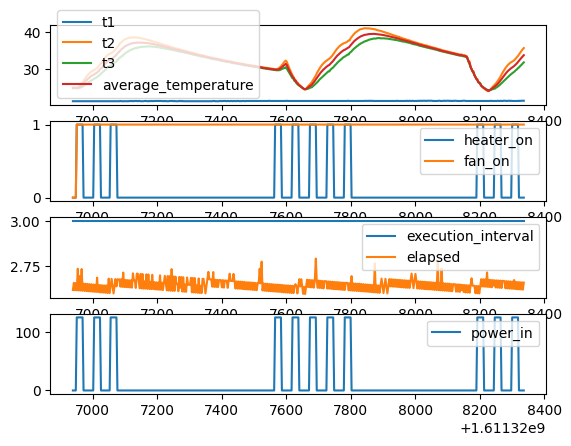

In [16]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)

ax1.plot(data["time"], data["t1"], label="t1")
ax1.plot(data["time"], data["t2"], label="t2")
ax1.plot(data["time"], data["t3"], label="t3")
ax1.plot(data["time"], data["average_temperature"], label="average_temperature")
ax1.legend()

ax2.plot(data["time"], data["heater_on"], label="heater_on")
ax2.plot(data["time"], data["fan_on"], label="fan_on")
ax2.legend()

ax3.plot(data["time"], data["execution_interval"], label="execution_interval")
ax3.plot(data["time"], data["elapsed"], label="elapsed")
ax3.legend()

ax4.plot(data["time"], data["power_in"], label="power_in")
ax4.legend()

plt.show()

In [13]:
events

,time,event,timestamp_ns
0,1611327598000000000,Lid Opened,2021-01-22 14:59:58
1,1611327658000000000,Lid Closed,2021-01-22 15:00:58
2,1611328159000000000,Lid Opened,2021-01-22 15:09:19
3,1611328225000000000,Lid Closed,2021-01-22 15:10:25


In [14]:
# Inputs to _plant
measurements_heater = np.array([1.0 if b else 0.0 for b in data["heater_on"]])
measurements_Troom = data["t1"].to_numpy()

# System state measurements (partial)
measurements_T = data["average_temperature"].to_numpy()

kalman_prediction = []
kalman_prediction_prior_T = []
kalman_process_noise_Theater = []
kalman_process_noise_T = []
kalman_process_noise_Theater_prior = []
kalman_process_noise_T_prior = []
for i in range(len(measurements_heater)):
    f.predict(u=np.array([
            [measurements_heater[i]],
            [measurements_Troom[i]]
        ]))
    f.update(np.array([[measurements_T[i]]]))
    x = f.x
    kalman_process_noise_Theater_prior.append(np.sqrt(f.P_prior[0,0]))
    kalman_process_noise_T_prior.append(np.sqrt(f.P_prior[1,1]))
    kalman_process_noise_Theater.append(np.sqrt(f.P[0,0]))
    kalman_process_noise_T.append(np.sqrt(f.P[1,1]))
    kalman_prediction_prior_T.append(f.x_prior[1][0])
    kalman_prediction.append(x)

kalman_prediction = np.array(kalman_prediction).squeeze(2)
kalman_prediction


array([[25.07555877, 25.70062477],
       [25.43377343, 25.63574673],
       [25.98582107, 25.56492311],
       [26.65442293, 25.5236479 ],
       [28.45591776, 25.5239637 ],
       [29.96465797, 25.55570409],
       [31.37690323, 25.62605075],
       [32.7255742 , 25.73090773],
       [34.08559824, 25.87851825],
       [35.4428818 , 26.06426449],
       [36.79345811, 26.28487623],
       [36.72068152, 26.51581108],
       [36.75802086, 26.76364532],
       [36.83793321, 27.0140509 ],
       [36.94974382, 27.2665581 ],
       [37.06291714, 27.51165113],
       [37.1823474 , 27.75168715],
       [37.29026624, 27.97947134],
       [37.39606267, 28.19887064],
       [37.50472744, 28.41234851],
       [37.56745011, 28.59610173],
       [37.62102174, 28.76731266],
       [39.14755946, 28.95576906],
       [40.6167899 , 29.16357354],
       [42.01071573, 29.37587365],
       [43.34852177, 29.59859324],
       [44.64467869, 29.83609329],
       [45.92506201, 30.10016829],
       [47.18006488,

In [15]:
from data_handling import plotly_incubator_data

fig = plotly_incubator_data(data,
                            compare_to={
                                "Kalman": {
                                    "timestamp_ns": data["timestamp_ns"],
                                    "T": kalman_prediction[:, 1],
                                    "T_heater": kalman_prediction[:, 0]
                                },
                            },
                            heater_T_data={
                                "Kalman": {
                                    "timestamp_ns": data["timestamp_ns"],
                                    "T_heater": kalman_prediction[:, 0]
                                },
                            },
                            events=events,
                            overlay_heater=True,
                            show_hr_time=True)

# Save plotly interactive plot
import plotly.io as pio
pio.write_html(fig, file="incubator_KF.html")

fig

## Advanced Exercises

1. Create a service similar to the [NNBasedMonitoringService](../3-Physics-Modelling/5-NNBasedMonitoringService.ipynb) that uses a kalman filter instead. Essentially, each time a new temperature sample is available, the KF service should output a predicted temperature, predicted heater temperature, prediction error, and any other value you would like to output. Deploy it and test it with opening the lid. Note that you will have to adjust the physical system parameters above, to be the same as the physical system parameters used in the [PT Emulator](../5-IncubatorPTEmulator/1-IncubatorPTEmulator.ipynb), since the above dataset was from an earlier version of the incubator.
